In [1]:
import astropy
print(astropy.__version__)
from astropy import units as u
from astropy import time

import numpy as np

1.3


In [2]:
%matplotlib inline

from matplotlib import pyplot as plt

# Downloads 

In [3]:
!wget http://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de430.bsp

--2017-01-27 13:58:37--  http://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de430.bsp
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119741440 (114M) [text/plain]
Saving to: ‘de430.bsp’

de430.bsp           100%[=====================>] 114.19M  2.13MB/s   in 42s    

2017-01-27 13:59:19 (2.73 MB/s) - ‘de430.bsp’ saved [119741440/119741440]



In [4]:
!wget http://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de432s.bsp

--2017-01-27 13:59:19--  http://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de432s.bsp
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10895360 (10M) [text/plain]
Saving to: ‘de432s.bsp’

de432s.bsp          100%[=====================>]  10.39M  3.23MB/s   in 3.2s   

2017-01-27 13:59:22 (3.23 MB/s) - ‘de432s.bsp’ saved [10895360/10895360]



In [5]:
from jplephem.spk import SPK

In [6]:
de432 = SPK.open('de432s.bsp')
print(de432)

File type DAF/SPK and format LTL-IEEE with 14 segments:
2433264.50..2469808.50  Solar System Barycenter (0) -> Mercury Barycenter (1)
2433264.50..2469808.50  Solar System Barycenter (0) -> Venus Barycenter (2)
2433264.50..2469808.50  Solar System Barycenter (0) -> Earth Barycenter (3)
2433264.50..2469808.50  Solar System Barycenter (0) -> Mars Barycenter (4)
2433264.50..2469808.50  Solar System Barycenter (0) -> Jupiter Barycenter (5)
2433264.50..2469808.50  Solar System Barycenter (0) -> Saturn Barycenter (6)
2433264.50..2469808.50  Solar System Barycenter (0) -> Uranus Barycenter (7)
2433264.50..2469808.50  Solar System Barycenter (0) -> Neptune Barycenter (8)
2433264.50..2469808.50  Solar System Barycenter (0) -> Pluto Barycenter (9)
2433264.50..2469808.50  Solar System Barycenter (0) -> Sun (10)
2433264.50..2469808.50  Earth Barycenter (3) -> Moon (301)
2433264.50..2469808.50  Earth Barycenter (3) -> Earth (399)
2433264.50..2469808.50  Mercury Barycenter (1) -> Mercury (199)
243326

In [7]:
de430 = SPK.open('de430.bsp')
print(de430)

File type DAF/SPK and format LTL-IEEE with 14 segments:
2287184.50..2688976.50  Solar System Barycenter (0) -> Mercury Barycenter (1)
2287184.50..2688976.50  Solar System Barycenter (0) -> Venus Barycenter (2)
2287184.50..2688976.50  Solar System Barycenter (0) -> Earth Barycenter (3)
2287184.50..2688976.50  Solar System Barycenter (0) -> Mars Barycenter (4)
2287184.50..2688976.50  Solar System Barycenter (0) -> Jupiter Barycenter (5)
2287184.50..2688976.50  Solar System Barycenter (0) -> Saturn Barycenter (6)
2287184.50..2688976.50  Solar System Barycenter (0) -> Uranus Barycenter (7)
2287184.50..2688976.50  Solar System Barycenter (0) -> Neptune Barycenter (8)
2287184.50..2688976.50  Solar System Barycenter (0) -> Pluto Barycenter (9)
2287184.50..2688976.50  Solar System Barycenter (0) -> Sun (10)
2287184.50..2688976.50  Earth Barycenter (3) -> Moon (301)
2287184.50..2688976.50  Earth Barycenter (3) -> Earth (399)
2287184.50..2688976.50  Mercury Barycenter (1) -> Mercury (199)
228718

In [8]:
tnow = time.Time.now()
jdnow = tnow.tdb.jd

In [9]:
earth = de430[0, 3]
sun = de430[0, 10]
# yields sun->earth vectors

pos1, vel1 = earth.compute_and_differentiate(jdnow)
pos2, vel2 = sun.compute_and_differentiate(jdnow)
pos = pos1 - pos2
vel = vel1 - vel2

vkms_now_jpl = (vel*(u.km/u.day)).to(u.km/u.s)
vkms_now_jpl, np.sum(vkms_now_jpl**2)**0.5

(<Quantity [-24.02110694,-16.85552605, -7.30688454] km / s>,
 <Quantity 30.24091431956689 km / s>)

(0, 365.0)

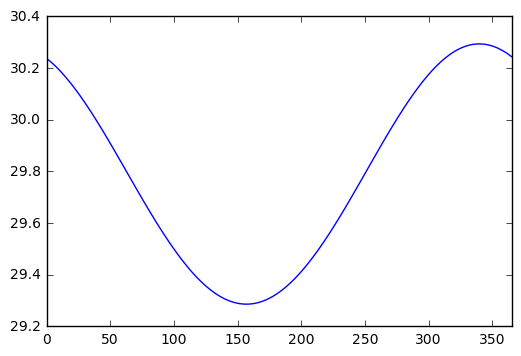

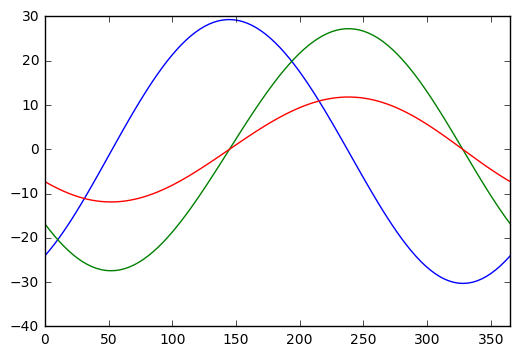

In [10]:
dday = np.linspace(0, 365,100)*u.day
tnow_year = tnow + dday

pos, vel = earth.compute_and_differentiate(tnow_year.tdb.jd)
vkms_jpl = (vel*(u.km/u.day)).to(u.km/u.s)

plt.plot(dday, np.sum(vkms_jpl**2, axis=0)**0.5)
plt.xlim(0, dday[-1].value)

plt.figure()
for i in range(3):
    plt.plot(dday, vkms_jpl[i])
plt.xlim(0, dday[-1].value)

# Compare to astropy discrete derivatives 

In [11]:
from astropy import coordinates

In [12]:
sun0 = coordinates.get_body('sun', tnow-0.5*u.second)
sun1 = coordinates.get_body('sun', tnow+0.5*u.second)

dc = sun0.cartesian - sun1.cartesian  # this difference is bary->earth
vkms_now_apy = dc.xyz.to(u.km)/u.s
vkms_now_apy

<Quantity [-24.03270525,-16.86056384, -7.30796709] km / s>

In [13]:
vkms_now_apy - vkms_now_jpl

<Quantity [-0.01159831,-0.00503779,-0.00108255] km / s>

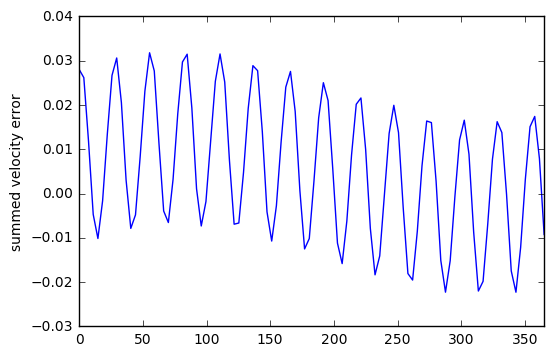

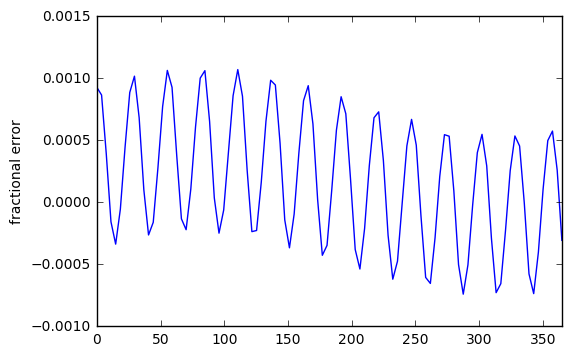

In [14]:
sun0 = coordinates.get_body('sun', tnow_year-0.5*u.second)
sun1 = coordinates.get_body('sun', tnow_year+0.5*u.second)

dc = sun0.cartesian - sun1.cartesian  # this difference is bary->earth
vkms_apy = dc.xyz.to(u.km)/u.s
plt.plot(dday, np.sum(vkms_jpl-vkms_apy, axis=0))
plt.xlim(0, dday[-1].value)
plt.ylabel('summed velocity error')

plt.figure()
plt.plot(dday, np.sum(vkms_jpl-vkms_apy, axis=0)*np.sum(vkms_jpl**2, axis=0)**-0.5)
plt.xlim(0, dday[-1].value)
plt.ylabel('fractional error')

# Compare to erfa epv00 

In [15]:
(ph, vh), (pb, vb) = erfa.epv00(tnow.tdb.jd1, tnow.tdb.jd2)
pos_now_erfa = pb*u.AU
vkms_now_erfa = (vb*u.AU/u.day).to(u.km/u.s)
vkms_now_erfa

NameError: name 'erfa' is not defined

In [ ]:
vkms_now_erfa - vkms_now_jpl

In [ ]:
vkms_now_erfa - vkms_now_apy

In [ ]:
pvh, pvb = erfa.epv00(tnow_year.tdb.jd1, tnow_year.tdb.jd2)


pos_now_erfa = pvb[:,0,:]*u.AU
vkms_now_erfa = (pvb[:,1,:]*u.AU/u.day).to(u.km/u.s)
vkms_now_erfa


plt.plot(dday, np.sum(vkms_jpl-vkms_apy, axis=0))
plt.xlim(0, dday[-1].value)
plt.ylabel('summed velocity error')

plt.figure()
plt.plot(dday, np.sum(vkms_jpl-vkms_apy, axis=0)*np.sum(vkms_jpl**2, axis=0)**-0.5)
plt.xlim(0, dday[-1].value)
plt.ylabel('fractional error')